In [1]:
import torch

from idt.data import data

num_features, num_classes, train_loader, val_loader, train_val_batch, test_batch = data('AIDS', 10, 0, seed=42)
    
bincount = torch.bincount(train_val_batch.y, minlength=2)
weight = len(train_val_batch) / (2 * bincount.float())

In [2]:
from lightning import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from idt.gnn import GNN

torch.set_float32_matmul_precision('high')

GCN = GNN(num_features, num_classes, layers=8, dim=128, activation="ReLU", conv="GCN", aggr="mean", lr=1e-4, weight=weight)
early_stop_callback = EarlyStopping(monitor="GCN_val_loss", patience=10, mode="min")

trainer = Trainer(
    max_steps=1000,
    enable_checkpointing=False,
    enable_progress_bar=True,
    log_every_n_steps=1,
    callbacks=[early_stop_callback],
)
trainer.fit(GCN, train_dataloaders=train_loader, val_dataloaders=val_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/apluska/miniconda3/envs/test/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/apluska/miniconda3/envs/test/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


/home/apluska/miniconda3/envs/test/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Epoch 157: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s, v_num=2]


In [3]:
from idt.idt import IDT, get_activations

idt = IDT(width=8, sample_size=1000, layer_depth=2, max_depth=None, ccp_alpha=1e-3)
values = get_activations(train_val_batch, GCN)
idt.fit(train_val_batch, values, train_val_batch.y)
print(f"""
    GCN test accuracy: {(GCN(test_batch).argmax(-1) == test_batch.y).float().mean().item()}
    IDT test accuracy: {idt.accuracy(test_batch)}
    IDT F1 score:      {idt.f1_score(test_batch)}
    Fidelity:          {idt.fidelity(test_batch, GCN)}""")


    GCN test accuracy: 0.9049999713897705
    IDT test accuracy: 1.0
    IDT F1 score:      1.0
    Fidelity:          0.905


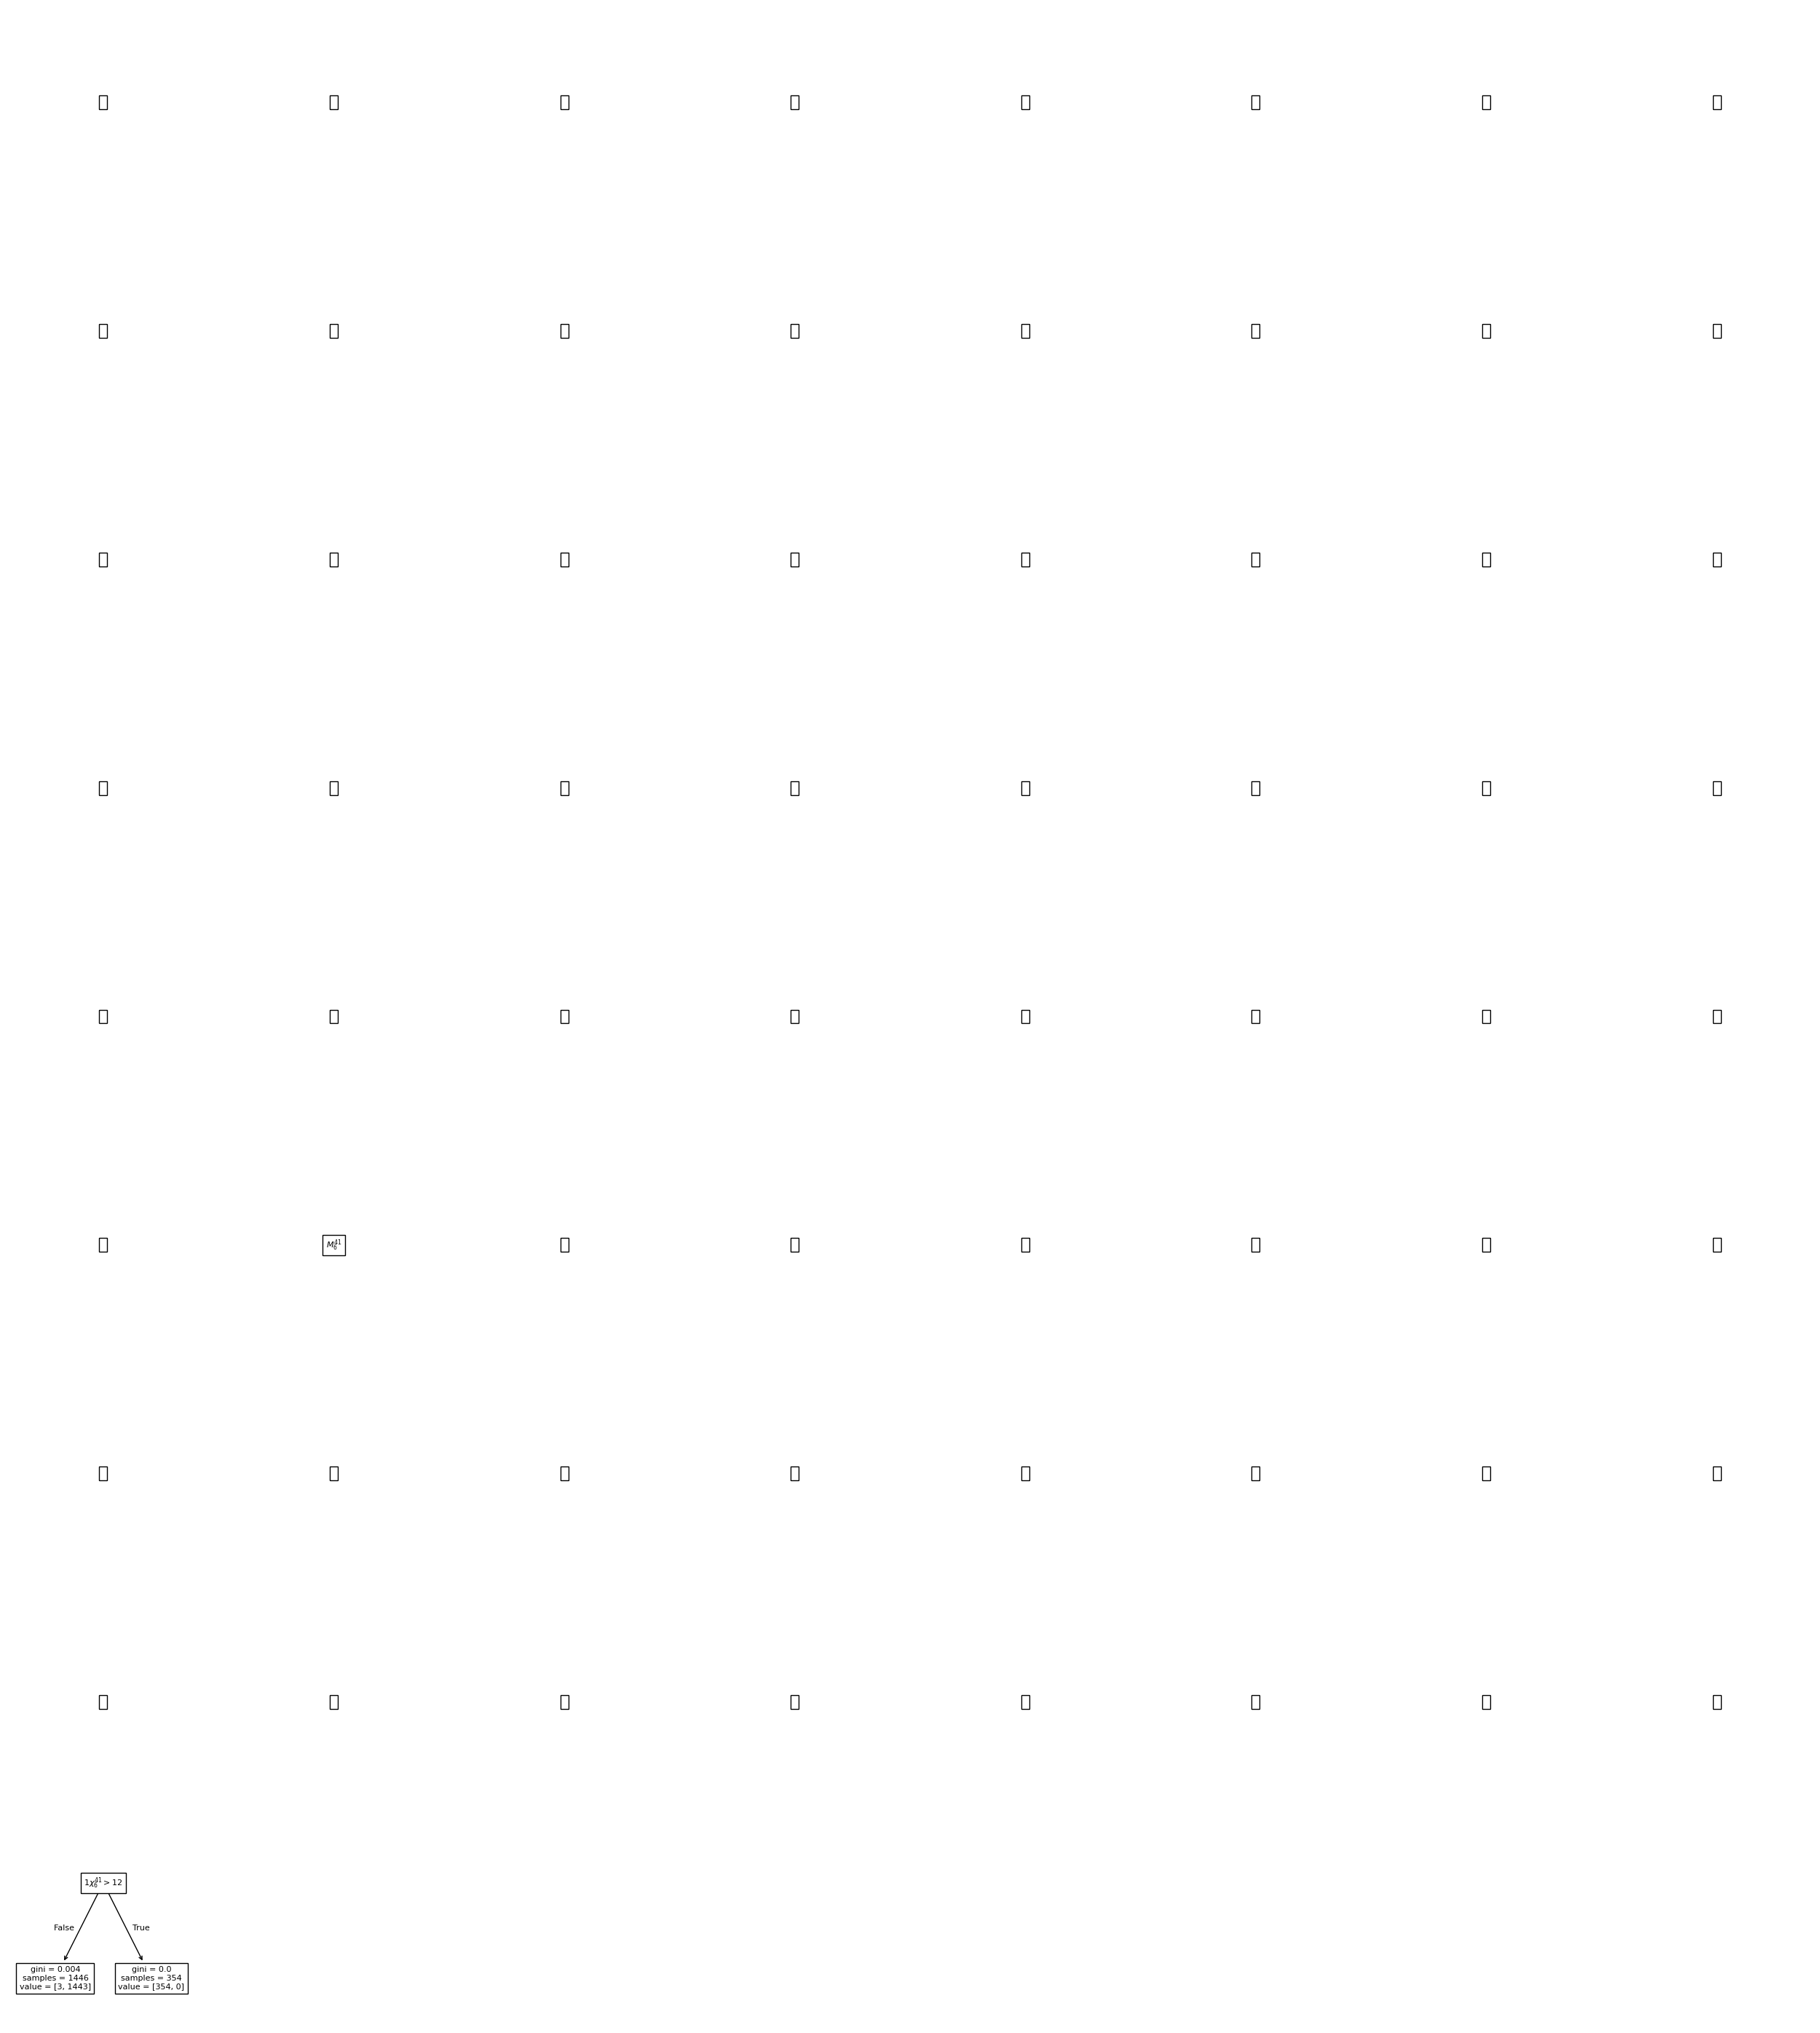

In [4]:
idt.prune()
idt.plot()